**Introduction**  
This deep learning problem is a binary classification problem where the goal is to determine whether a company will go bankrupt.

**Data Source**  
Liang, D., & Tsai, C.-F. (2024). Taiwanese Bankruptcy Prediction [Data set]. UCI Machine Learning Repository. https://archive.ics.uci.edu/ml/datasets/Taiwanese+Bankruptcy+Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier

**Exploratory Data Analysis (EDA)**  
This data set has a very large number of features 95 and the 1 label of bankrupt or not. So what we are going to do is use a correlation matrix to determine the top 20 features that we can potentially use to create our model. In the cells below for the EDA, I will:
1. Clean the data by checking for missing values and outliers and dropping any from the dataset
2. Print the clean data to visually check the data
3. Plot the correlation matrix (as you can see it's too large to analyze visually)
4. Extract the top features from the correlation matrix to make it easier work with, print the top 20 features and plot the top 5 features

In [2]:
file_path = 'Data/bankruptcy.csv'
data = pd.read_csv(file_path)

For cleaning we will check for any missing values and outliers and drop them from our dataset.

In [3]:
missing_values = data.isnull().sum()
for column in data.columns:
    if missing_values[column] > 0:
        data[column].fillna(data[column].median(), inplace=True)

z_scores = np.abs(stats.zscore(data.select_dtypes(include=[np.number])))
outlier_rows = np.where((z_scores > 3).all(axis=1))[0]

if len(outlier_rows) > 0:
    data_clean = data.drop(index=outlier_rows)
else:
    data_clean = data


In [4]:
print(data_clean.info())
print(data_clean.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

C:\Users\Kevin\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


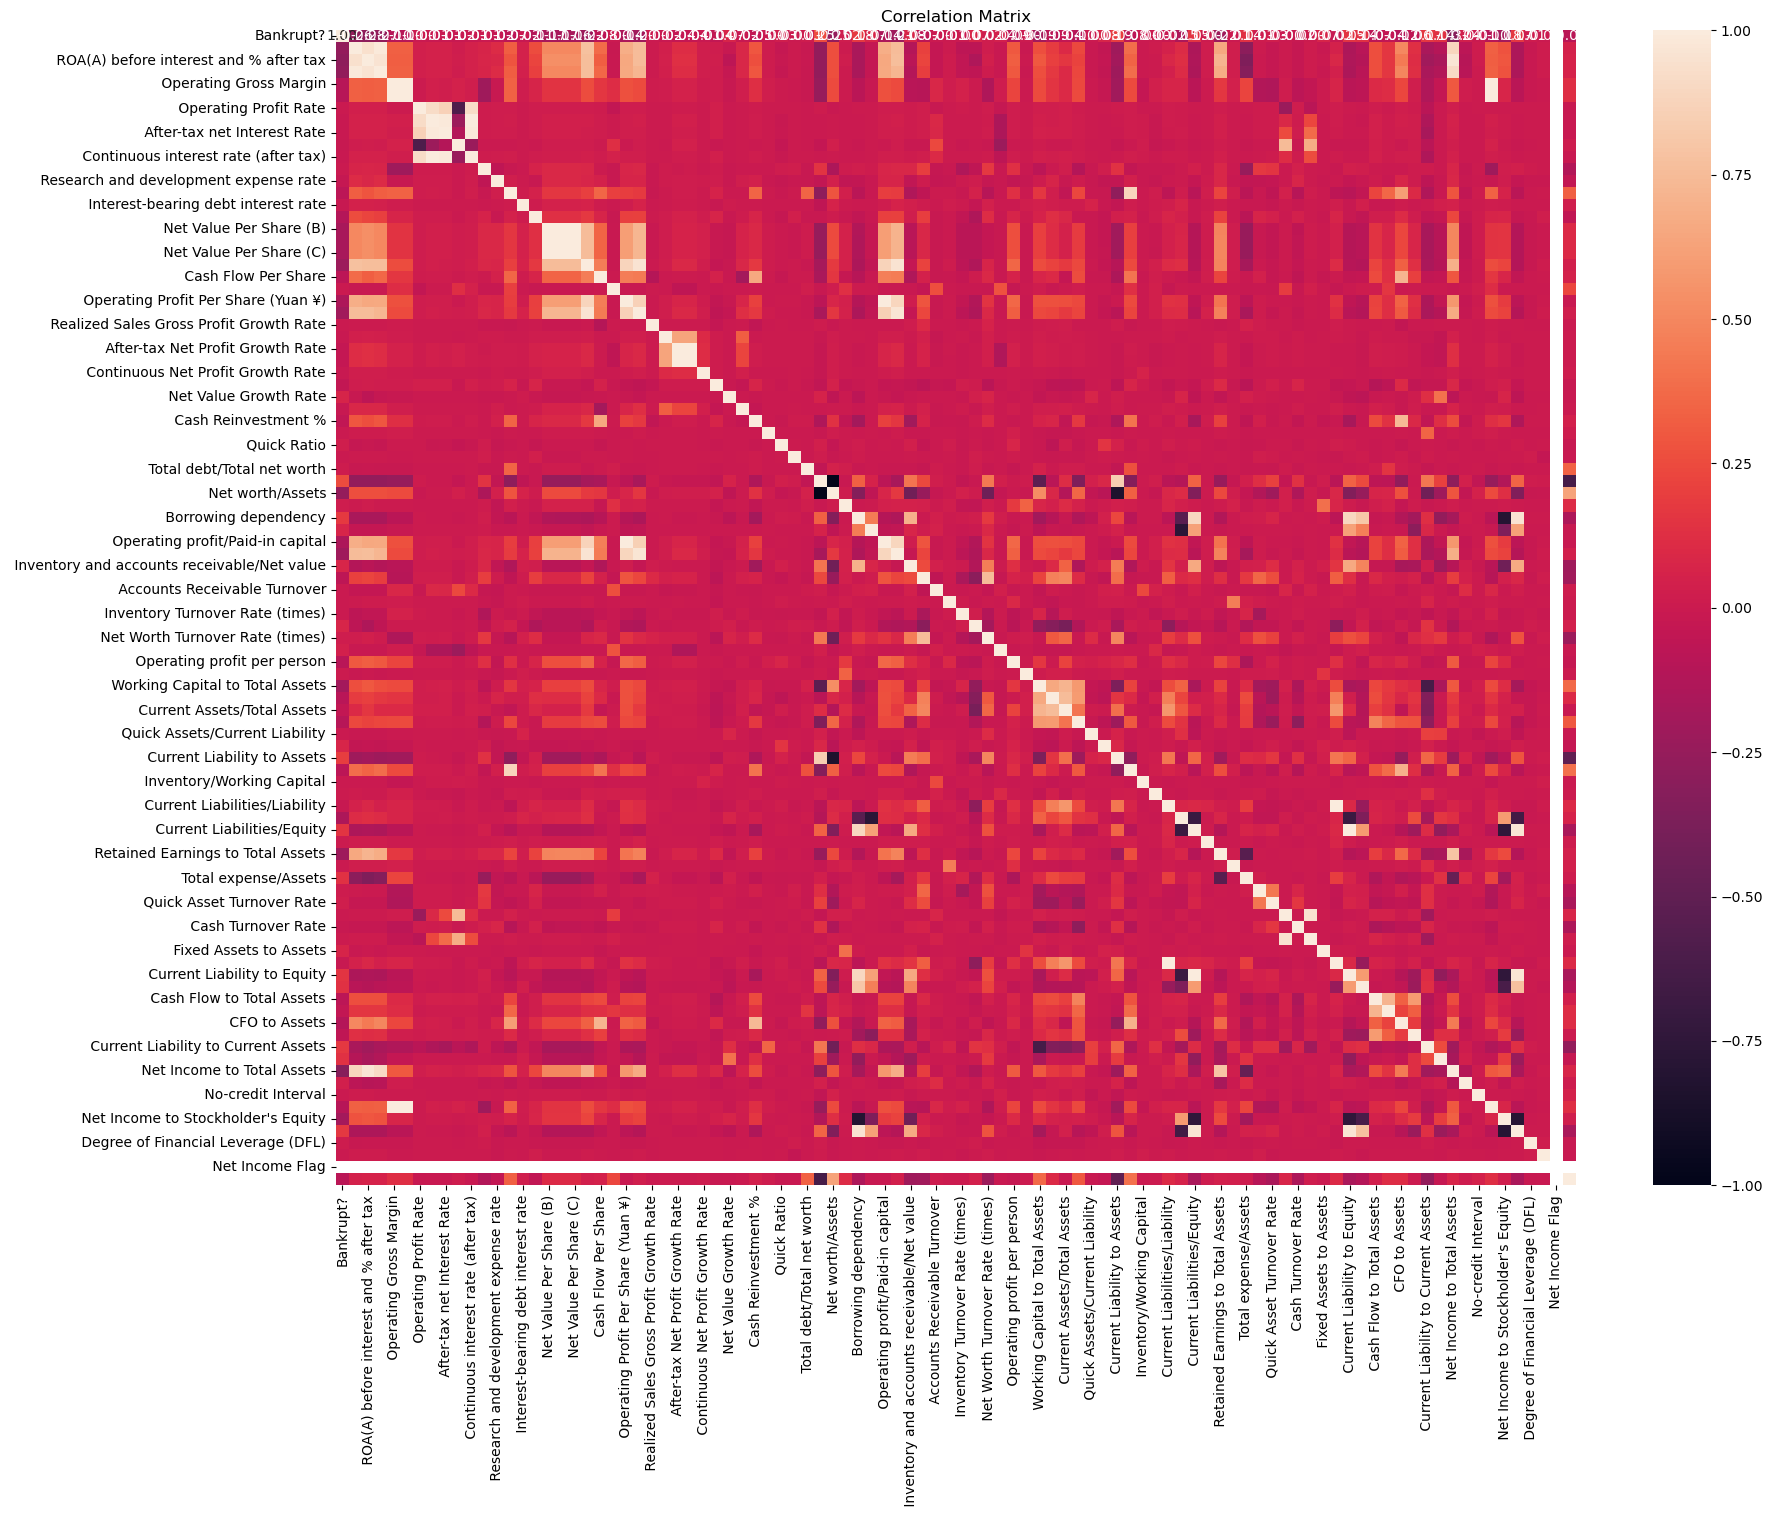

In [5]:
correlation_matrix = data_clean.corr()
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [6]:
top_features = correlation_matrix['Bankrupt?'].abs().sort_values(ascending=False)[1:21]
print("Top 20 features most correlated with 'Bankrupt?':")
print(top_features)

Top 20 features most correlated with 'Bankrupt?':
 Net Income to Total Assets                                 0.315457
 ROA(A) before interest and % after tax                     0.282941
 ROA(B) before interest and depreciation after tax          0.273051
 ROA(C) before interest and depreciation before interest    0.260807
 Net worth/Assets                                           0.250161
 Debt ratio %                                               0.250161
 Persistent EPS in the Last Four Seasons                    0.219560
 Retained Earnings to Total Assets                          0.217779
 Net profit before tax/Paid-in capital                      0.207857
 Per Share Net profit before tax (Yuan ¥)                   0.201395
 Current Liability to Assets                                0.194494
 Working Capital to Total Assets                            0.193083
 Net Income to Stockholder's Equity                         0.180987
 Borrowing dependency                                

C:\Users\Kevin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


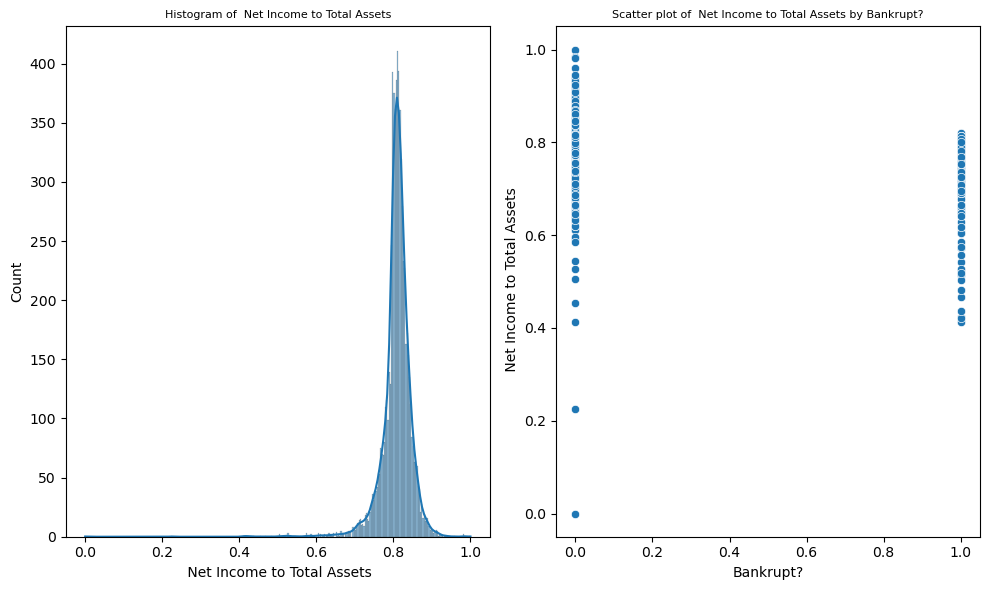

C:\Users\Kevin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


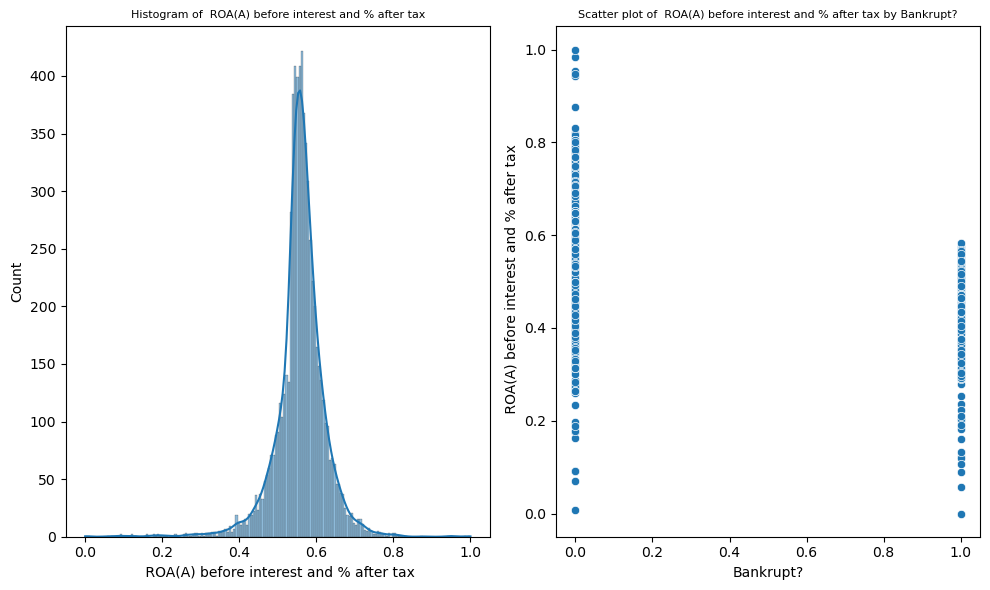

C:\Users\Kevin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


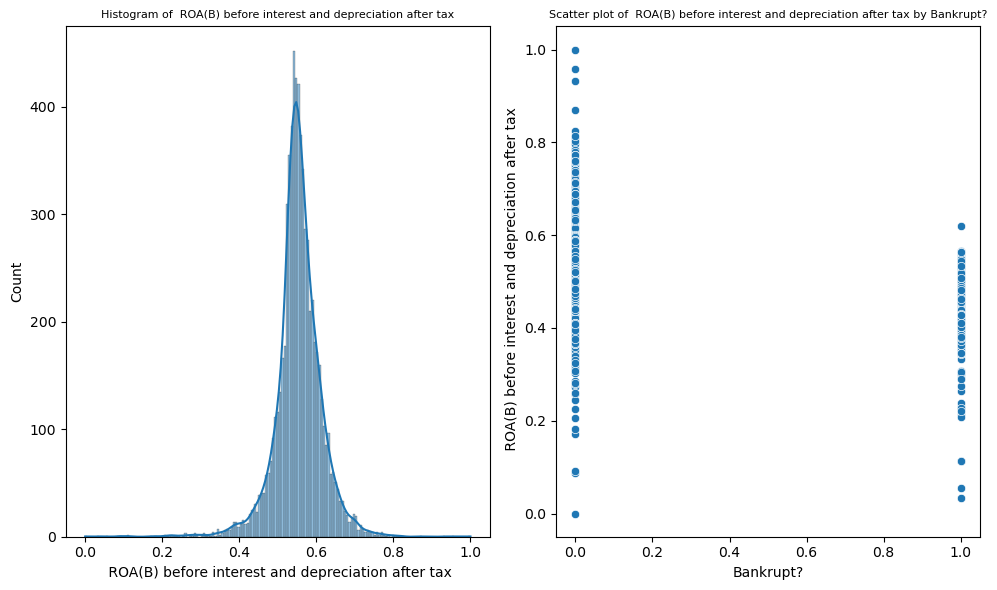

C:\Users\Kevin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


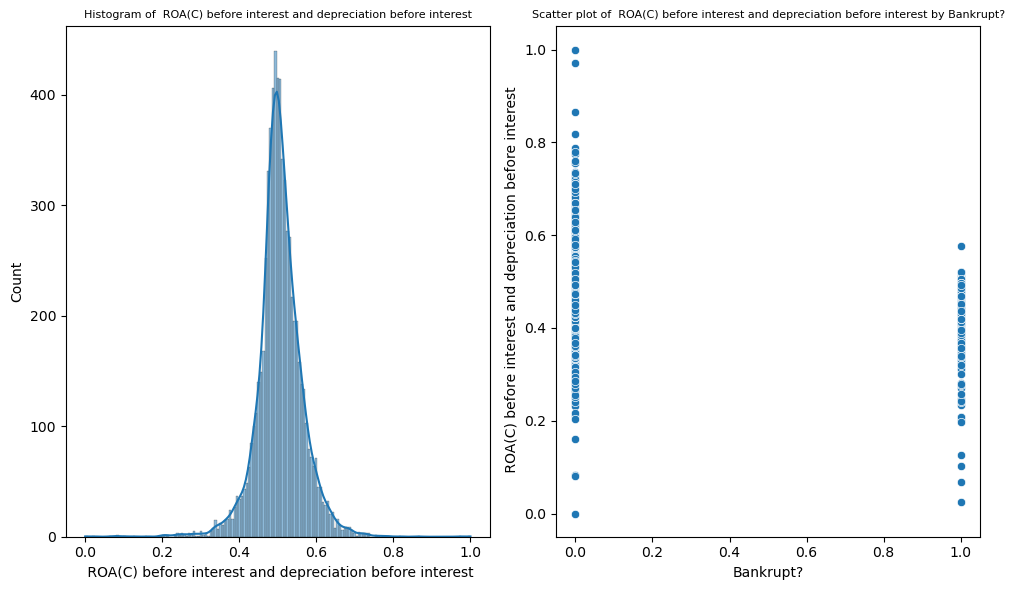

C:\Users\Kevin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


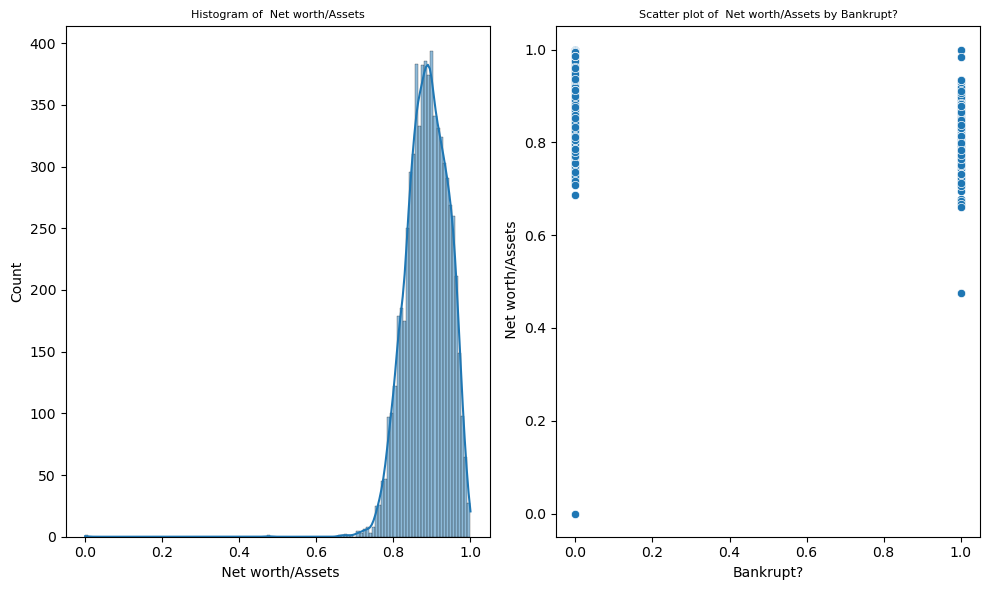

In [7]:
top_5_features = top_features.head(5)
for feature in top_5_features.index:
    plt.figure(figsize=(10, 6))
    
    plt.subplot(1, 2, 1)
    sns.histplot(data[feature], kde=True)
    plt.title(f"Histogram of {feature}", fontsize=8)
    
    plt.subplot(1, 2, 2)
    sns.scatterplot(x='Bankrupt?', y=feature, data=data)
    plt.title(f"Scatter plot of {feature} by Bankrupt?", fontsize=8)
    
    plt.tight_layout()
    plt.show()

**EDA Continued**  
From this analysis the plan of approach is going to be comparing two different deep learning architectures so we can compare and see any trade-offs.
The goal is to see which performs best in performance, interpretability and complexity.

**Analysis using Deep Learning**  
Here I will implement 3 models a simple neural network for a baseline, a deep neural network for comparison and a decision tree clasifier. This will tell us if there is significant benefit to adding more layers to the neural network and also give a separate model for outside comparison.

In [8]:
top_feature_names = top_features.index.tolist()
X = data_clean[top_feature_names]
y = data_clean['Bankrupt?']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [9]:
def build_simple_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [10]:
def build_deep_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [11]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred = (y_pred > 0.5).astype(int)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    
    return accuracy, precision, recall, f1, roc_auc

In [12]:
simple_model = build_simple_model(X_train.shape[1])
deep_model = build_deep_model(X_train.shape[1])

dt_classifier = DecisionTreeClassifier(random_state=1)
dt_classifier.fit(X_train, y_train)

simple_metrics = evaluate_model(simple_model, X_test, y_test)
print("Simple Neural Network Performance:")
print(f"Accuracy: {simple_metrics[0]:.4f}, Precision: {simple_metrics[1]:.4f}, Recall: {simple_metrics[2]:.4f}, F1-Score: {simple_metrics[3]:.4f}, ROC-AUC: {simple_metrics[4]:.4f}")

deep_metrics = evaluate_model(deep_model, X_test, y_test)
print("\nDeep Neural Network Performance:")
print(f"Accuracy: {deep_metrics[0]:.4f}, Precision: {deep_metrics[1]:.4f}, Recall: {deep_metrics[2]:.4f}, F1-Score: {deep_metrics[3]:.4f}, ROC-AUC: {deep_metrics[4]:.4f}")

print("\nDecision Tree Classifier Performance:")
dt_metrics = evaluate_model(dt_classifier, X_test, y_test)
print(f"Accuracy: {dt_metrics[0]:.4f}, Precision: {dt_metrics[1]:.4f}, Recall: {dt_metrics[2]:.4f}, F1-Score: {dt_metrics[3]:.4f}, ROC-AUC: {dt_metrics[4]:.4f}")



43/43 [==============================] - 0s 691us/step
Simple Neural Network Performance:
Accuracy: 0.0367, Precision: 0.0367, Recall: 1.0000, F1-Score: 0.0707, ROC-AUC: 0.5000
43/43 [==============================] - 0s 620us/step

Deep Neural Network Performance:
Accuracy: 0.9633, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000, ROC-AUC: 0.5000

Decision Tree Classifier Performance:
Accuracy: 0.9516, Precision: 0.3000, Recall: 0.2400, F1-Score: 0.2667, ROC-AUC: 0.6093


C:\Users\Kevin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Analysis and Conclusions**  
When running and rerunning these models there are a lot of insights that came about from their results. The neural networks for this dataset were very inconsistent, sometimes having perfect accuracy but very low precision and recall. This means that they were failing to identify any of the positive cases correctly. The decision tree classifier however performed more consistenly, although with relatively low precision. This is because this dataset is very skewed, as there are a lot more businesses that aren't bankrupt than there are bankrupt. The decision tree classifier seemed to  be a lot more cautious in determining if something was going to be bankrupt. the ROC-AUC for the decision tree being at 60.93% was a lot better than the other classes meaning it has a much better capability of discriminating between the classes.  
For future developments it would make sense to look into undersampling, class weights or other techniques that could address the imbalance in the data.
